In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_45288/555797462.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Load in the data

In [3]:
path = "kaggle/input/open-university-learning-analytics-dataset/"
student_info = pd.read_csv(path + 'studentInfo.csv')
assessments = pd.read_csv(path + 'assessments.csv')
student_assessment = pd.read_csv(path + 'studentAssessment.csv')

In [4]:
assessments['weight'] = assessments['weight'].astype(int)

find missing values

In [28]:
student_info.isnull().sum()

code_module                 0
code_presentation           0
id_student                  0
gender                      0
region                      0
highest_education           0
imd_band                  998
age_band                    0
num_of_prev_attempts        0
studied_credits             0
disability                  0
final_result                0
score                       0
grade                       0
studied_credits_binned      0
dtype: int64

In [31]:
student_info['imd_band'].value_counts()

imd_band
30-40%     2780
20-30%     2749
10-20      2609
40-50%     2553
50-60%     2547
0-10%      2427
60-70%     2388
70-80%     2382
80-90%     2270
90-100%    2140
Name: count, dtype: int64

In [29]:
assessments.isnull().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

In [30]:
student_assessment.isnull().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

Get scores for each student, assign grade based on score as well

In [5]:
merged = pd.merge(student_assessment, assessments, on='id_assessment')
merged['weighted_score'] = merged['score'] * merged['weight']
grouped = merged.groupby(['id_student', 'code_module', 'code_presentation']).agg({'weighted_score': 'sum', 'weight': 'sum'}).reset_index()
grouped['score'] = grouped['weighted_score'] / grouped['weight']
student_scores = grouped[['id_student', 'code_module', 'code_presentation', 'score']]
student_info = pd.merge(student_info, student_scores, on=['id_student', 'code_module', 'code_presentation'])
grades = {
    "A+": 90,
    "A": 85,
    "A-": 80,
    "B+": 77,
    "B": 73,
    "B-": 70,
    "C+": 67,
    "C": 63,
    "C-": 60,
    "D+": 57,
    "D": 53,
    "D-": 50,
    "F": 0
}
sorted_grades = sorted(grades.items(), key=lambda x: x[1])

student_info['grade'] = ''

for grade, bound in sorted_grades:
    student_info.loc[student_info['score'] >= bound, 'grade'] = grade

student_info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,score,grade
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,82.4,A-
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,65.4,C
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,76.3,B
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,55.0,D
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,66.9,C


In [6]:
print("# records:", len(student_info))
print("# records without assignments:",len(student_info.loc[(student_info['score'] < 50) & (student_info['final_result'] == 'Pass') | (student_info['final_result'] == 'Distinction')]))

# records: 25843
# records without assignments: 3418


 categorical correlation analysis

In [7]:
student_info['num_of_prev_attempts'] = student_info['num_of_prev_attempts'].astype('category')
bins = [29, 60, 100, 200, 630]
labels = ['30-60', '61-100', '101-200', '201+']
student_info['studied_credits_binned'] = pd.cut(student_info['studied_credits'], bins, labels=labels)


In [8]:
student_info_numerical = student_info.copy()

student_info_numerical = pd.get_dummies(student_info_numerical, columns=['code_module', 'code_presentation', 'gender', 'region'])
bool_cols = student_info_numerical.columns[student_info_numerical.dtypes == 'bool']
student_info_numerical[bool_cols] = student_info_numerical[bool_cols].astype(int)

student_info_numerical['highest_education'] = student_info_numerical['highest_education'].map({
    "No Formal quals": 0, 
    "Lower Than A Level": 1, 
    "A Level or Equivalent": 2, 
    "HE Qualification": 3,
    "Post Graduate Qualification": 4
})

student_info_numerical['imd_band'] = student_info_numerical['imd_band'].map({
    "0-10%": 0,
    "10-20": 1,
    "20-30%": 2,
    "30-40%": 3,
    "40-50%": 4,
    "50-60%": 5,
    "60-70%": 6,
    "70-80%": 7,
    "80-90%": 8,
    "90-100%": 9
})

student_info_numerical['age_band'] = student_info_numerical['age_band'].map({
    "0-35": 0,
    "35-55": 1,
    "55<=": 2
})

student_info_numerical['num_of_prev_attempts'] = student_info_numerical['num_of_prev_attempts'].astype(int)

student_info_numerical['disability'] = student_info_numerical['disability'].map({
    "N": 0,
    "Y": 1
})

student_info_numerical['final_result'] = student_info_numerical['final_result'].map({
    "Withdrawn": -1,
    "Fail": 0,
    "Pass": 1,
    "Distinction": 2
})
student_info_numerical = student_info_numerical.drop(columns=['studied_credits_binned', 'grade'])

In [9]:
from sklearn.impute import KNNImputer

# Select rows where score is less than 50 and final_result is either 1 or 2
mask = (student_info_numerical['score'] < 49) & (student_info_numerical['final_result'].isin([1, 2]))

# Replace 'score' with NaN in the selected rows
student_info_numerical.loc[mask, 'score'] = np.nan

# Use KNN to fill in missing values
imputer = KNNImputer(n_neighbors=5)
student_info_numerical['score'] = imputer.fit_transform(student_info_numerical)[:, student_info_numerical.columns.get_loc('score')]

In [10]:
#bring score back into student_info
student_info['score'] = student_info.index.map(student_info_numerical['score'])
for grade, bound in sorted_grades:
    student_info.loc[student_info['score'] >= bound, 'grade'] = grade

In [11]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

categorical_columns = student_info.select_dtypes(include=['category', 'object']).columns
cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        cramers_v_matrix.loc[col1, col2] = cramers_v(student_info[col1], student_info[col2])

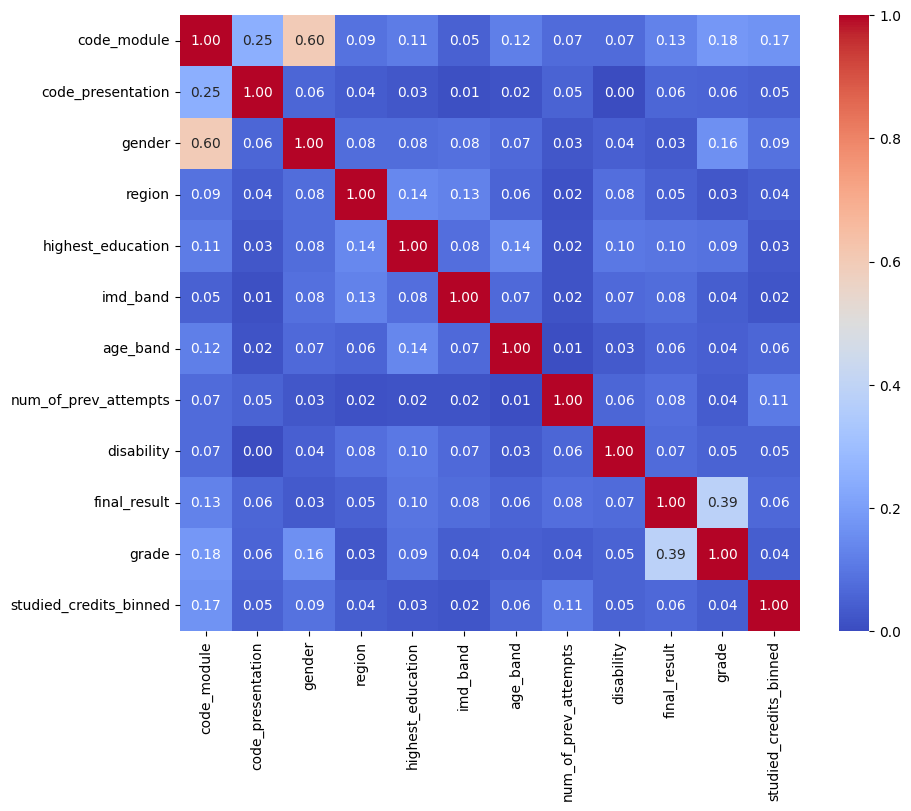

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix.astype(float), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

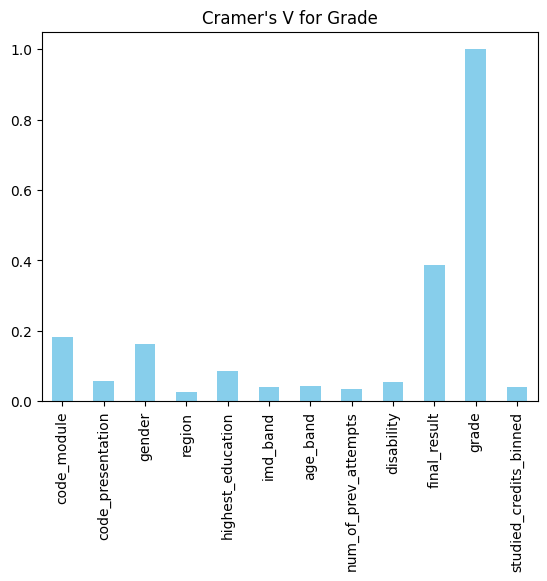

In [13]:
cramers_v_matrix['grade'].plot(kind='bar', color='skyblue')
plt.title('Cramer\'s V for Grade')
plt.show()

numerical correlation analysis

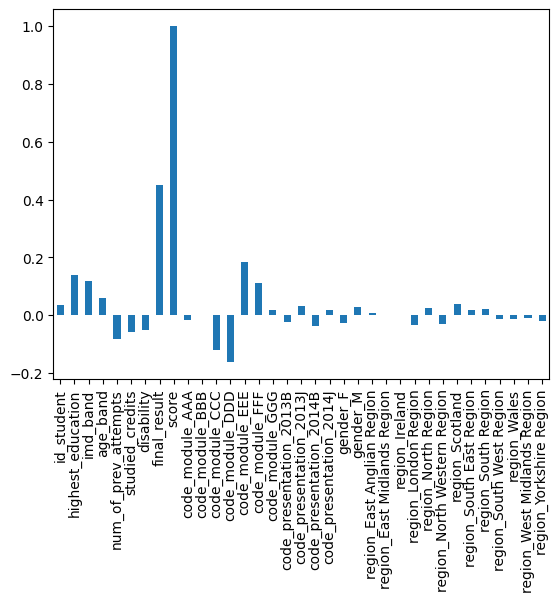

In [14]:
correlation_matrix = student_info_numerical.corr()
score = correlation_matrix['score']
score.plot(kind='bar')
plt.show()

univariate analysis

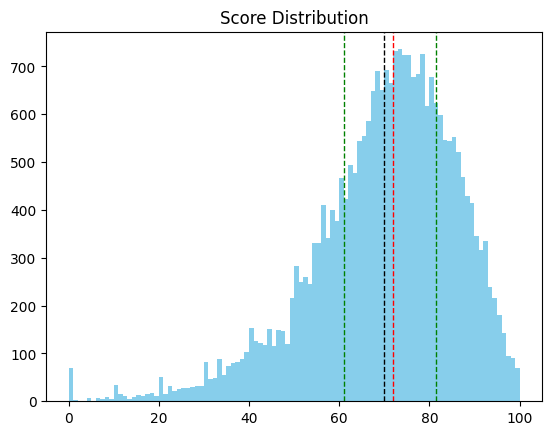

In [15]:
#score
q1 = student_info_numerical['score'].quantile(0.25)
q3 = student_info_numerical['score'].quantile(0.75)
iqr = q3 - q1

plt.hist(student_info_numerical['score'], bins=100, color='skyblue')
plt.axvline(student_info_numerical['score'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(student_info_numerical['score'].median(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(q1, color='g', linestyle='dashed', linewidth=1)
plt.axvline(q3, color='g', linestyle='dashed', linewidth=1)
plt.title('Score Distribution')
plt.show()

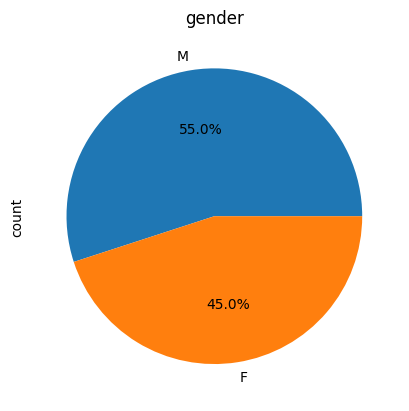

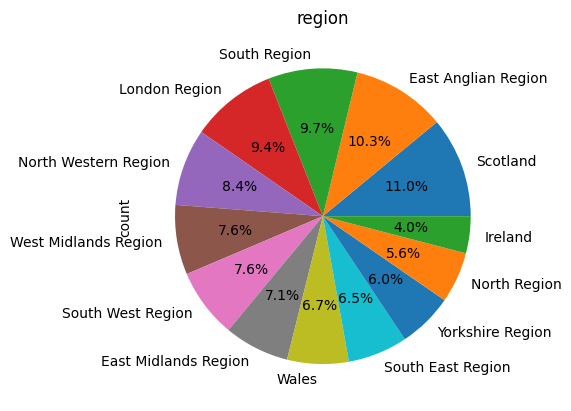

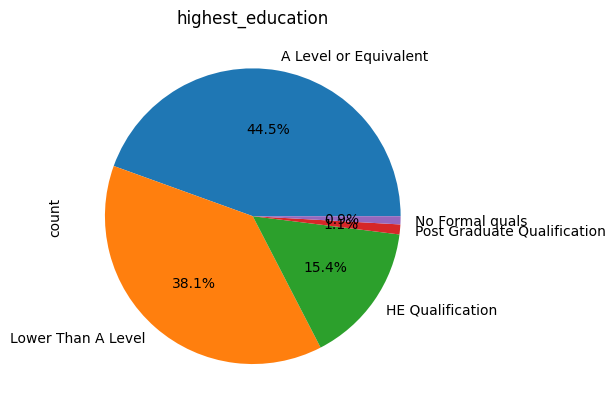

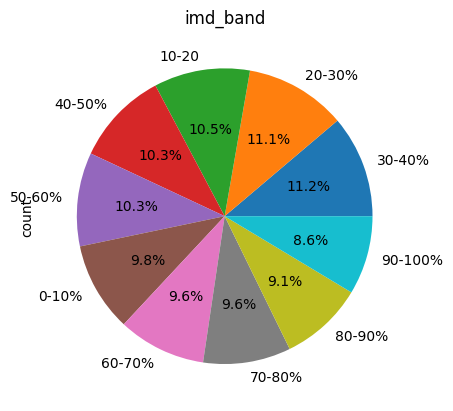

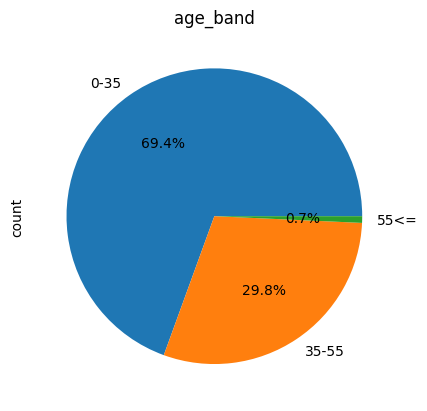

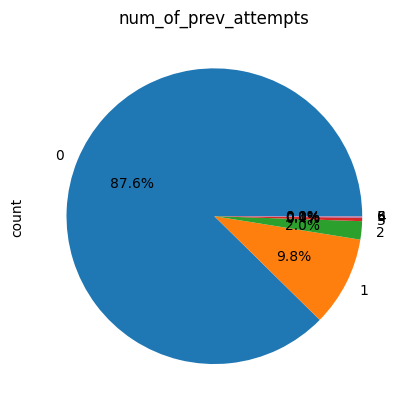

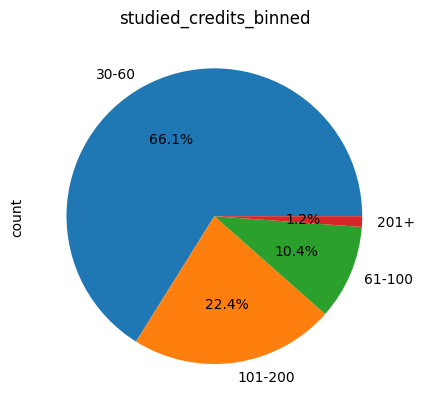

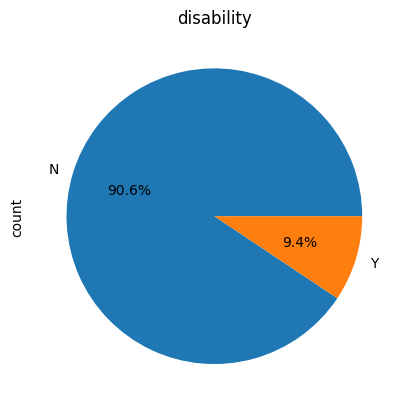

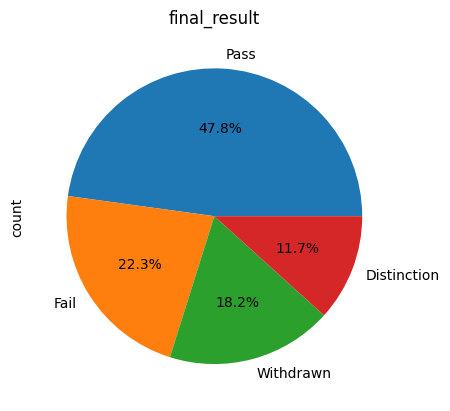

In [25]:
columns = ['gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits_binned', 'disability', 'final_result']
for i, column in enumerate(columns):
    plt.figure(i)
    student_info[column].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title(column)
    plt.show()


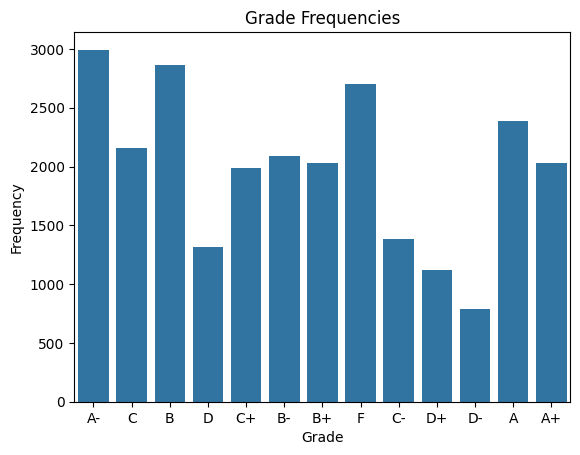

In [26]:
sns.countplot(x='grade', data=student_info)
plt.title('Grade Frequencies')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.show()

[]

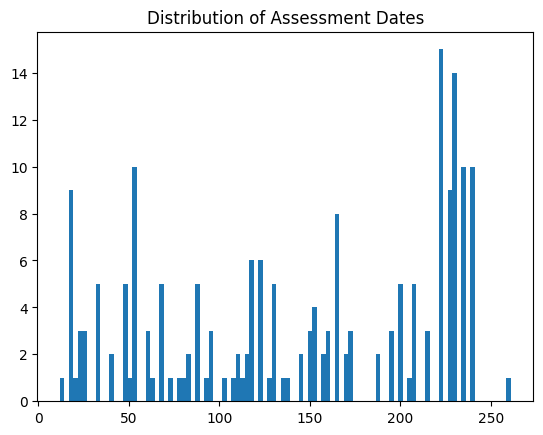

In [18]:
plt.hist(assessments['date'], bins=100)
plt.title("Distribution of Assessment Dates")
plt.plot()

[]

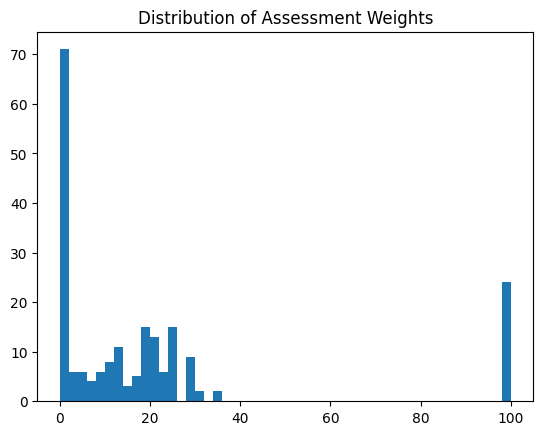

In [17]:
plt.hist(assessments['weight'], bins=50)
plt.title("Distribution of Assessment Weights")
plt.plot()

Text(0.5, 1.0, 'Assessment Type Distribution')

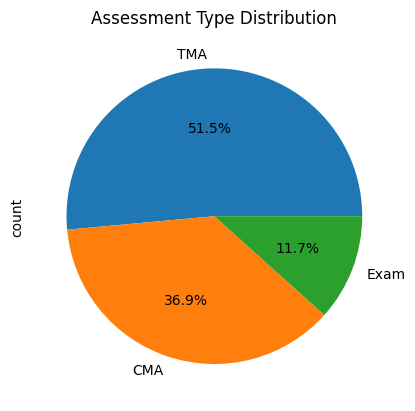

In [23]:
assessments["assessment_type"].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Assessment Type Distribution")
    

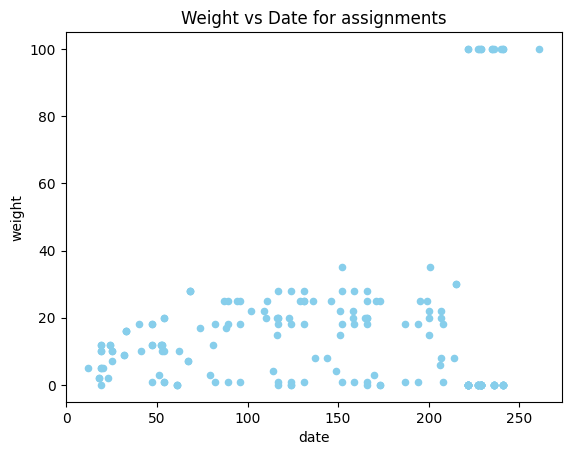

In [22]:
assessments.plot.scatter(x='date', y='weight', color='skyblue')
plt.title('Weight vs Date for assignments')
plt.show()